In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
from mpl_toolkits.mplot3d import proj3d
import itertools

# The Problem

* Exact dimensions of 3D plot are dependent of view angles (azim and elev)
* ideally, the entire canvas is used, regardless of orientation of the plot

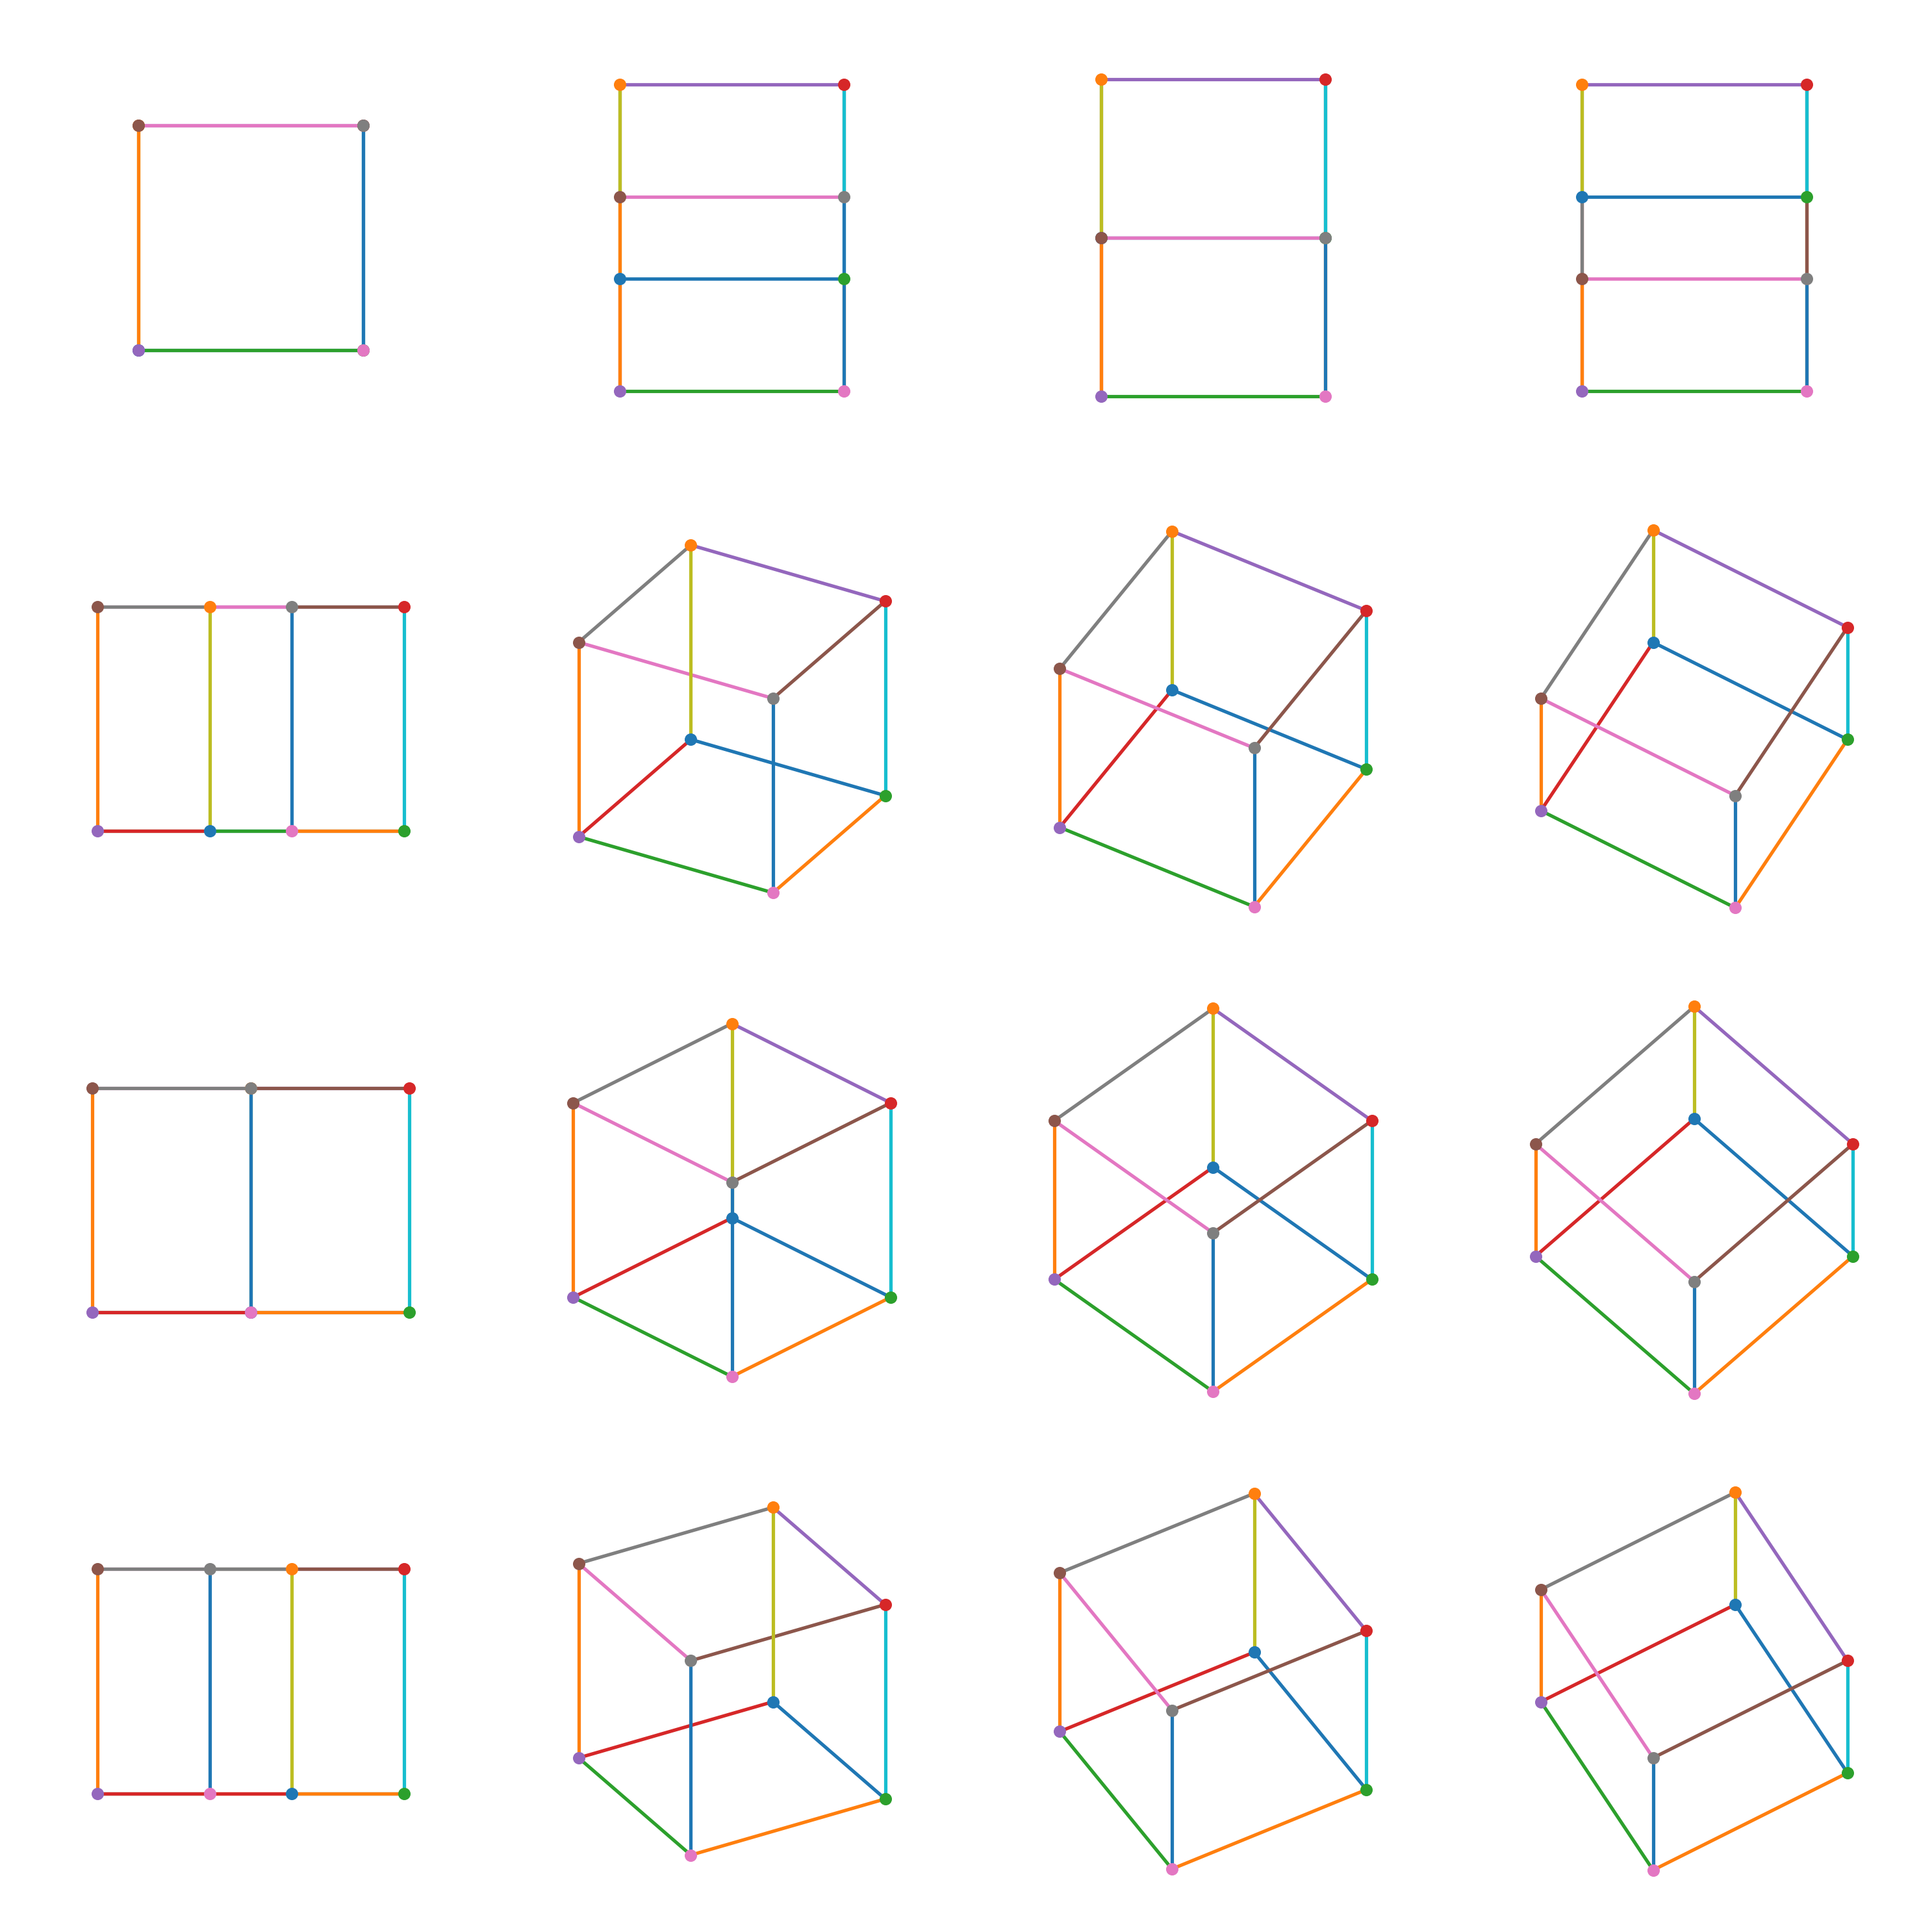

In [2]:
rc_params = get_rc_params(4, 4, (3, 3))
with plt.rc_context(rc_params):
    fig, axes = subplots_3D(4, 4)
    axes = np.ravel(axes)
    for i, (azim, elev) in enumerate(itertools.product([0, 30, 45, 60], [0, 30, 45, 60])):
        ax = axes[i]
        ax.set_axis_off()
        plot_cube_3D(ax)
        set_axes_3D_equal(ax)
        ax.view_init(azim=azim, elev=elev)
    plt.savefig("1_problem.png")

# The Solution

* calculate projection of data manually
* then calculate scaling based on x / y extend
* patch the projection matrix and plot again

In [3]:
def _proj_fix(axes, kappa):
    def _fix(*args, **kwargs):
        """Manually increase zoom"""
        projM = np.diag([2, 2, -2, 20]) * np.diag([kappa, kappa, kappa, 1])
        return projM

    axes._projection = _fix

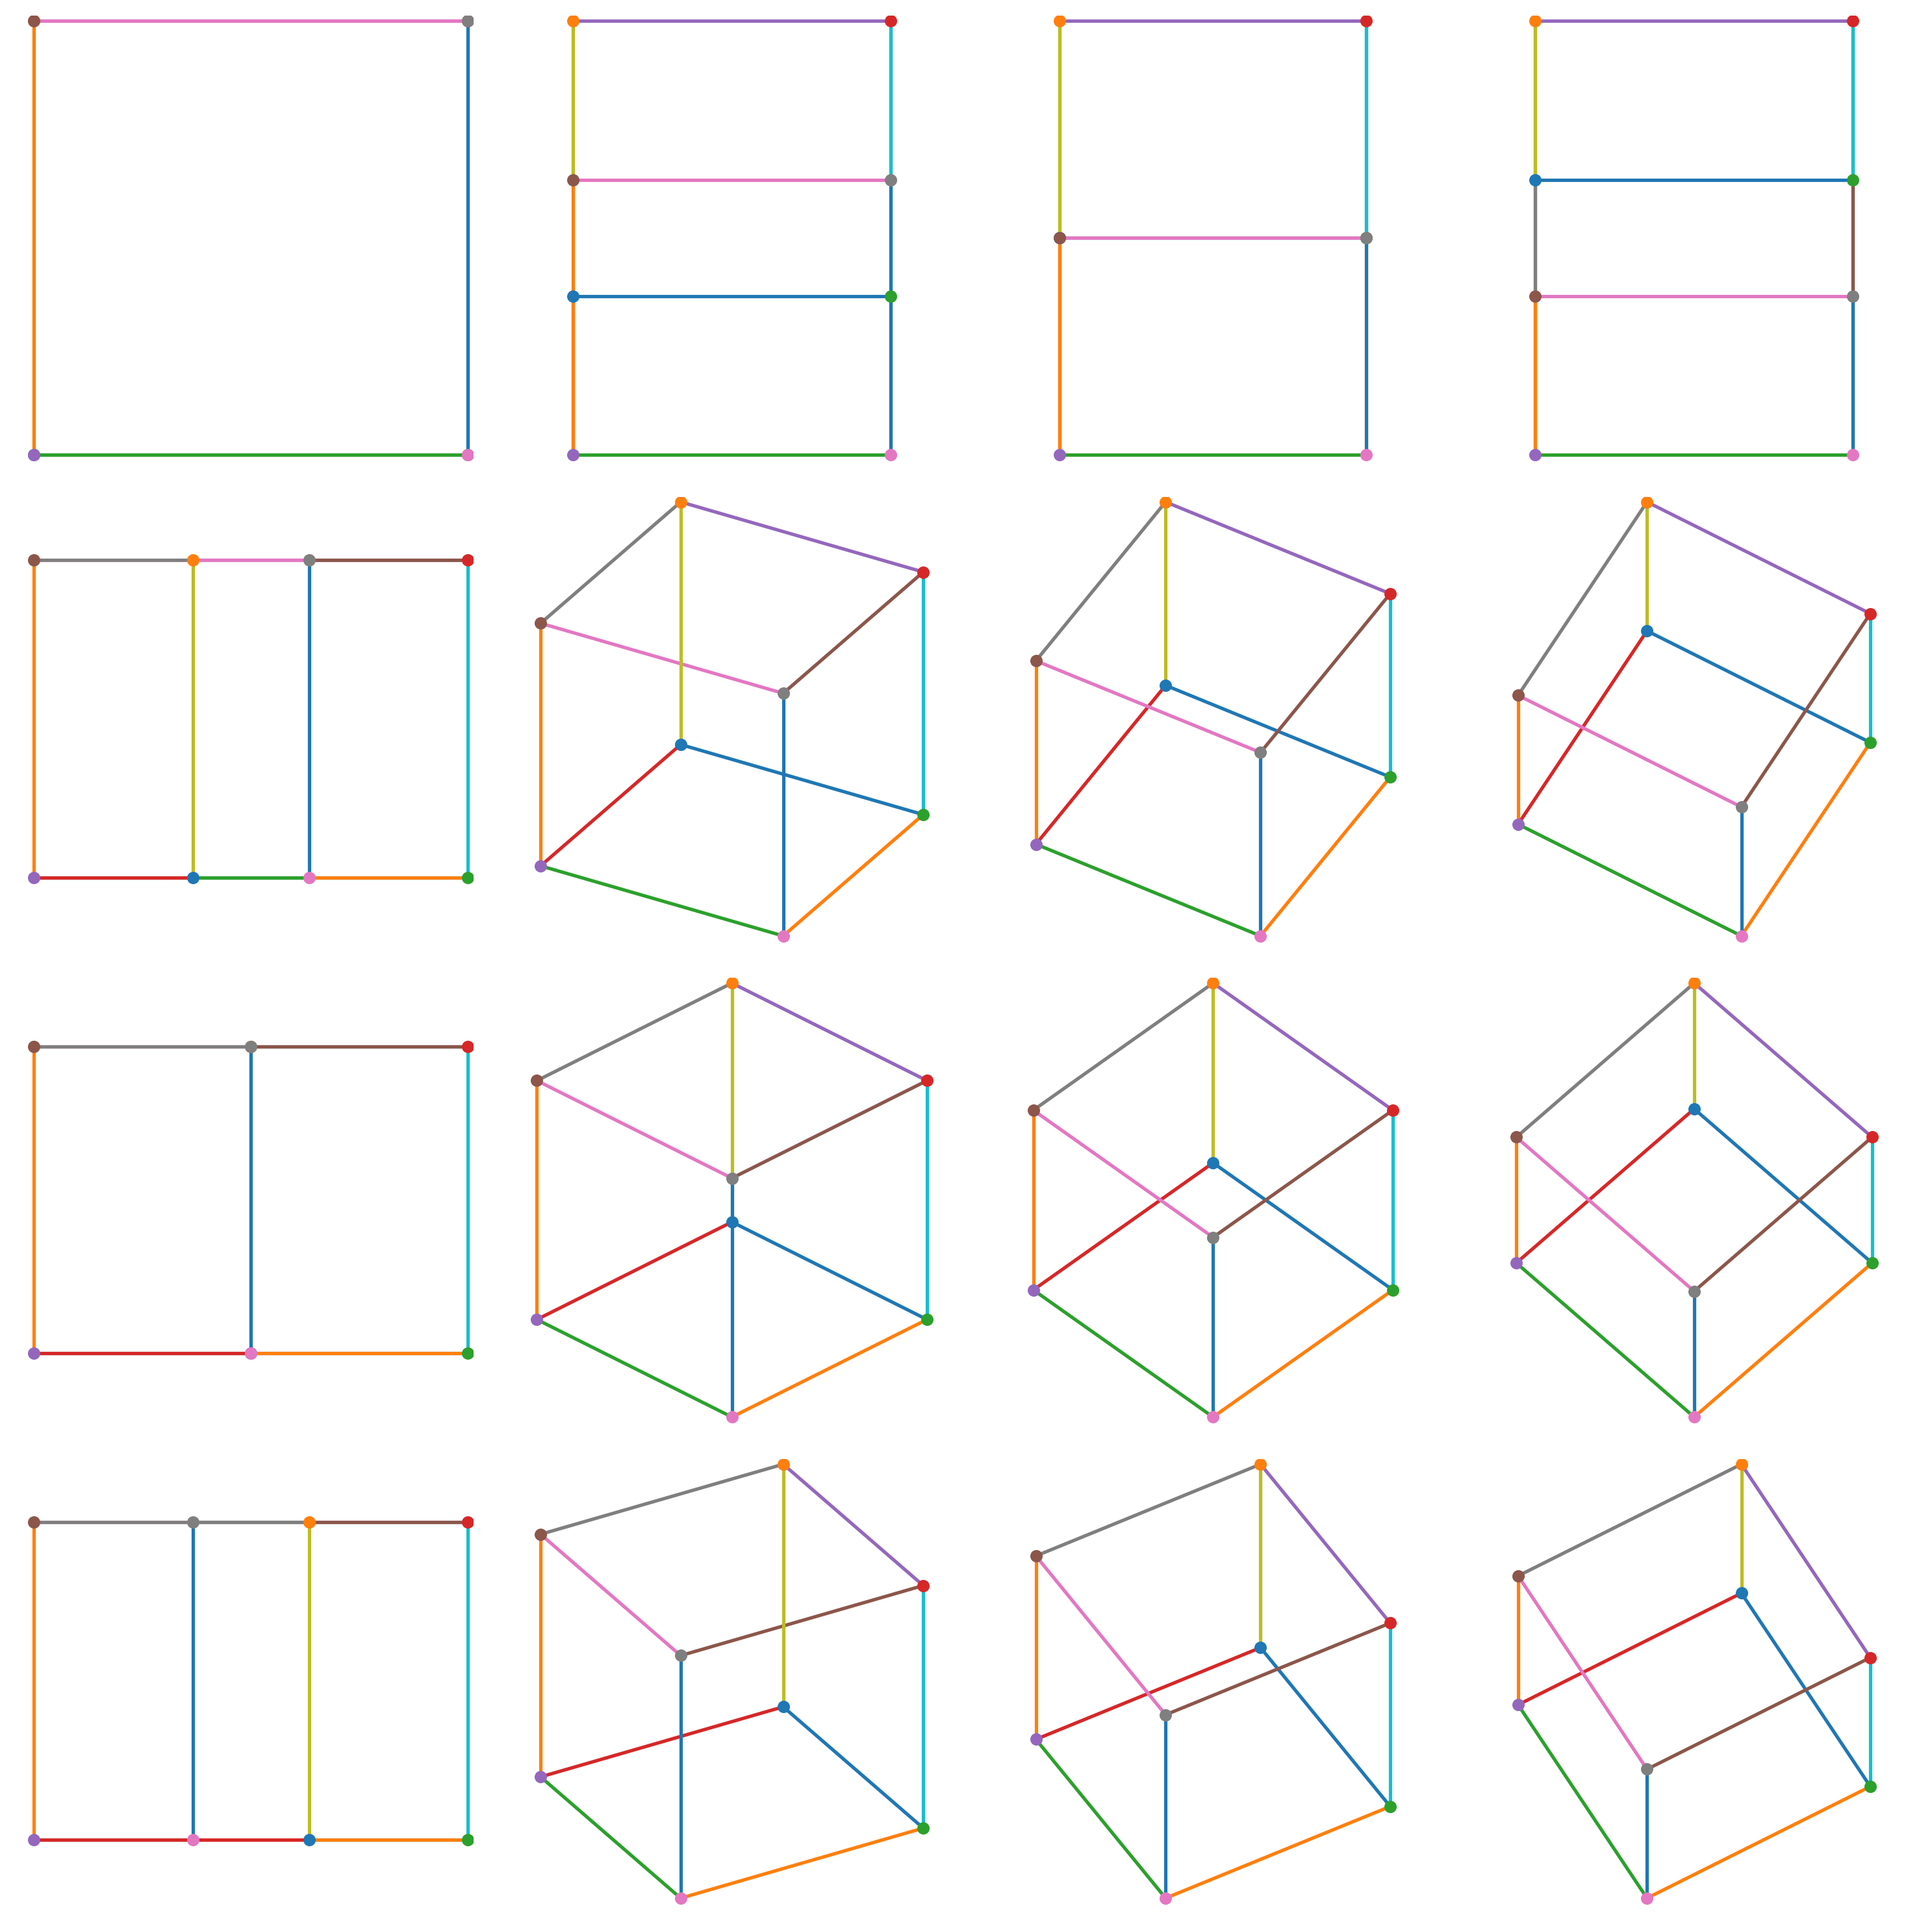

In [16]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
rc_params = get_rc_params(4, 4, (3, 3))
with plt.rc_context(rc_params):
    fig, axes = subplots_3D(4, 4)
    axes = np.ravel(axes)
    for i, (azim, elev) in enumerate(itertools.product([0, 30, 45, 60], [0, 30, 45, 60])):
        ax = axes[i]
        set_axes_3D_equal(ax)
        plot_cube_3D(ax)
        ax.view_init(azim=azim, elev=elev) # view init has to be called first, otherwise calculation is off

        # Fix scale
        data3d = get_data_3D(ax)
        limits = calculate_limits(data3d)
        corners = corners3D(*limits)
        xs3d, ys3d, zs3d = [x.squeeze() for x in np.split(corners, 3, axis=1)]
        M = ax.get_proj()
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, M)
        kappa_x = ax._pseudo_h / (np.max(xs) - np.min(xs)) * 0.95 # small fix to get all points visible
        kappa_y = ax._pseudo_w / (np.max(ys) - np.min(ys)) * 0.95 # small fix to get all points visible
        kappa = min([kappa_x, kappa_y])
        _proj_fix(ax, kappa)
        # finish plotting regularly
        ax.set_axis_off()

    plt.savefig("2_fix.png")

# Tiny improvement

`ax.__dict__` contains margins

```python
{
    '_xmargin': 0.05,
    '_ymargin': 0.05,
}
```

Let's try to set them to 0

--> does not work yet

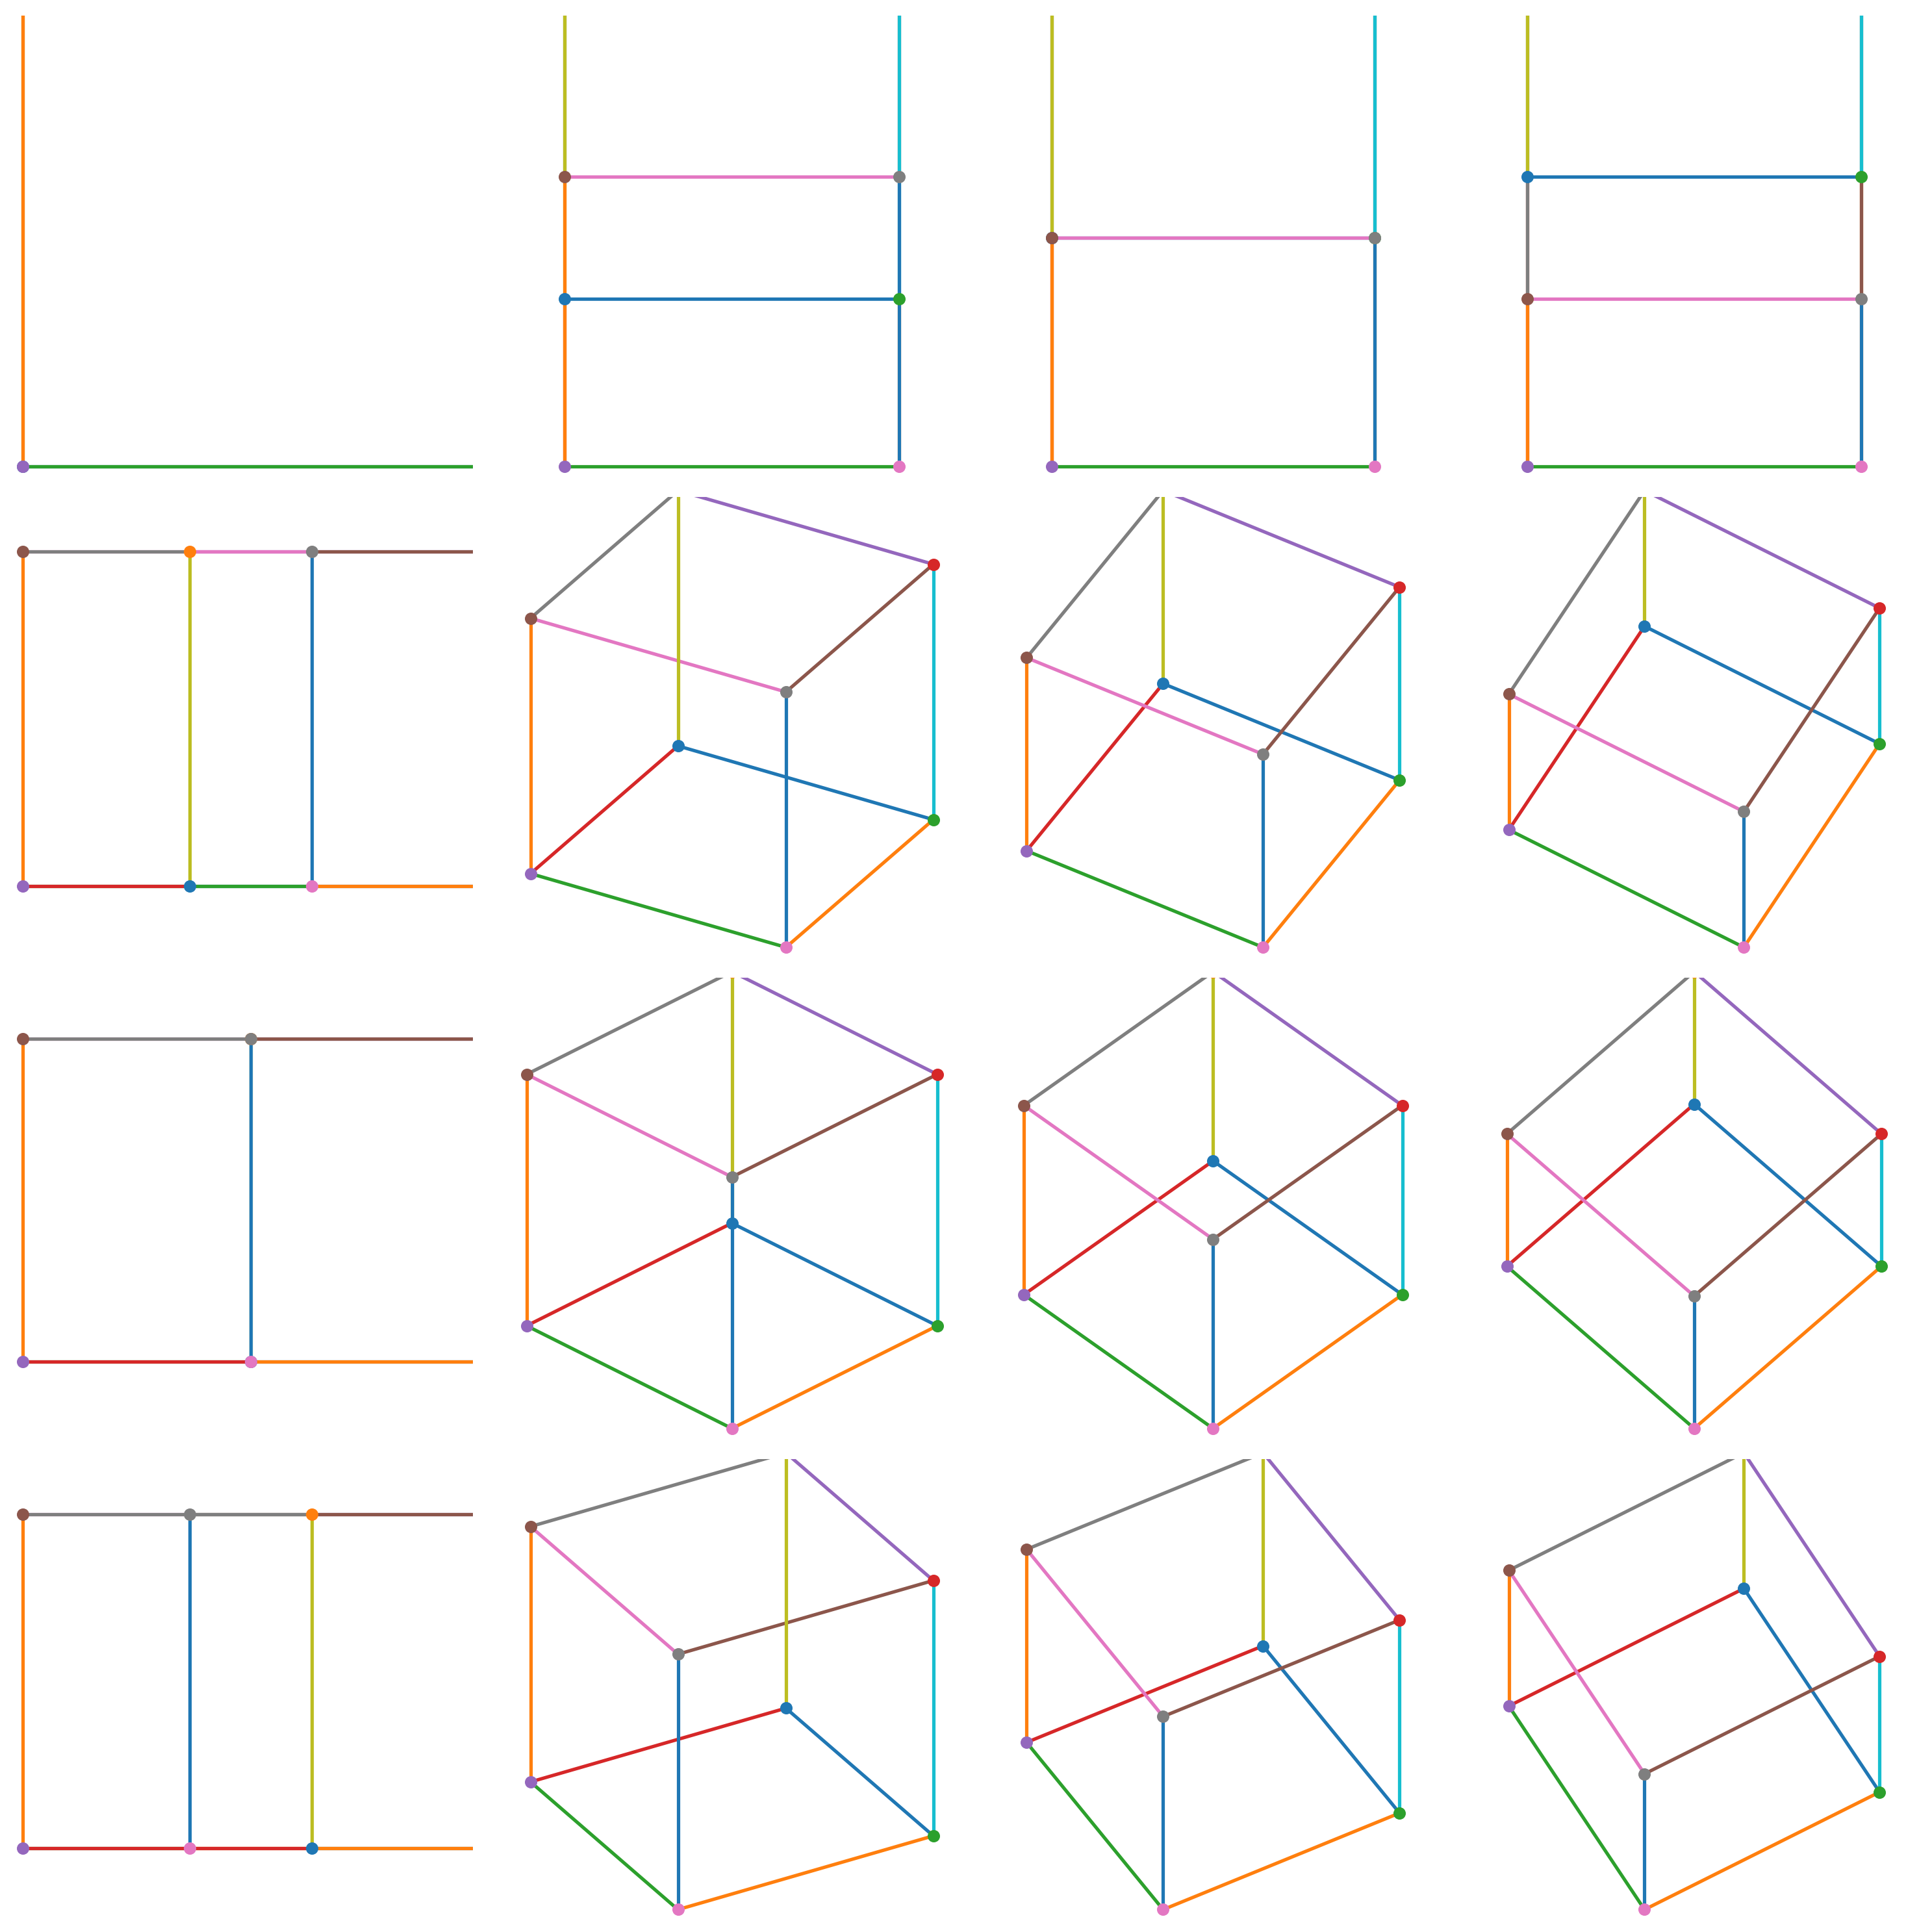

In [28]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
rc_params = get_rc_params(4, 4, (3, 3))
with plt.rc_context(rc_params):
    fig, axes = subplots_3D(4, 4)
    axes = np.ravel(axes)
    for i, (azim, elev) in enumerate(itertools.product([0, 30, 45, 60], [0, 30, 45, 60])):
        ax = axes[i]
        set_axes_3D_equal(ax)
        plot_cube_3D(ax)
        ax.view_init(azim=azim, elev=elev) # view init has to be called first, otherwise calculation is off

        # Fix scale
        data3d = get_data_3D(ax)
        limits = calculate_limits(data3d)
        corners = corners3D(*limits)
        xs3d, ys3d, zs3d = [x.squeeze() for x in np.split(corners, 3, axis=1)]
        M = ax.get_proj()
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, M)
        kappa_x = ax._pseudo_h / (np.max(xs) - np.min(xs))
        kappa_y = ax._pseudo_w / (np.max(ys) - np.min(ys))
        kappa = min([kappa_x, kappa_y])
        _proj_fix(ax, kappa)
        # finish plotting regularly
        ax.set_axis_off()
        ax._xmargin=0.0
        ax._ymargin=0.0
        ax._viewLim = matplotlib.transforms.Bbox([[-0.1, -0.1], [0.1, 0.1]])
        ax.dataLim = matplotlib.transforms.Bbox([[0, 0], [1.1, 1.1]])


# Wrapping it up nicely

In [33]:
def _proj_fix_final(ax):
    data3d = get_data_3D(ax)
    limits = calculate_limits(data3d)
    corners = corners3D(*limits)
    xs3d, ys3d, zs3d = [x.squeeze() for x in np.split(corners, 3, axis=1)]
    M = ax.get_proj()
    xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, M)
    kappa_x = ax._pseudo_h / (np.max(xs) - np.min(xs)) * 0.95 # small fix to get all points visible
    kappa_y = ax._pseudo_w / (np.max(ys) - np.min(ys)) * 0.95 # small fix to get all points visible
    kappa = min([kappa_x, kappa_y])
    def _fix(*args, **kwargs):
        """Manually increase zoom"""
        projM = np.diag([2, 2, -2, 20]) * np.diag([kappa, kappa, kappa, 1])
        return projM

    ax._projection = _fix

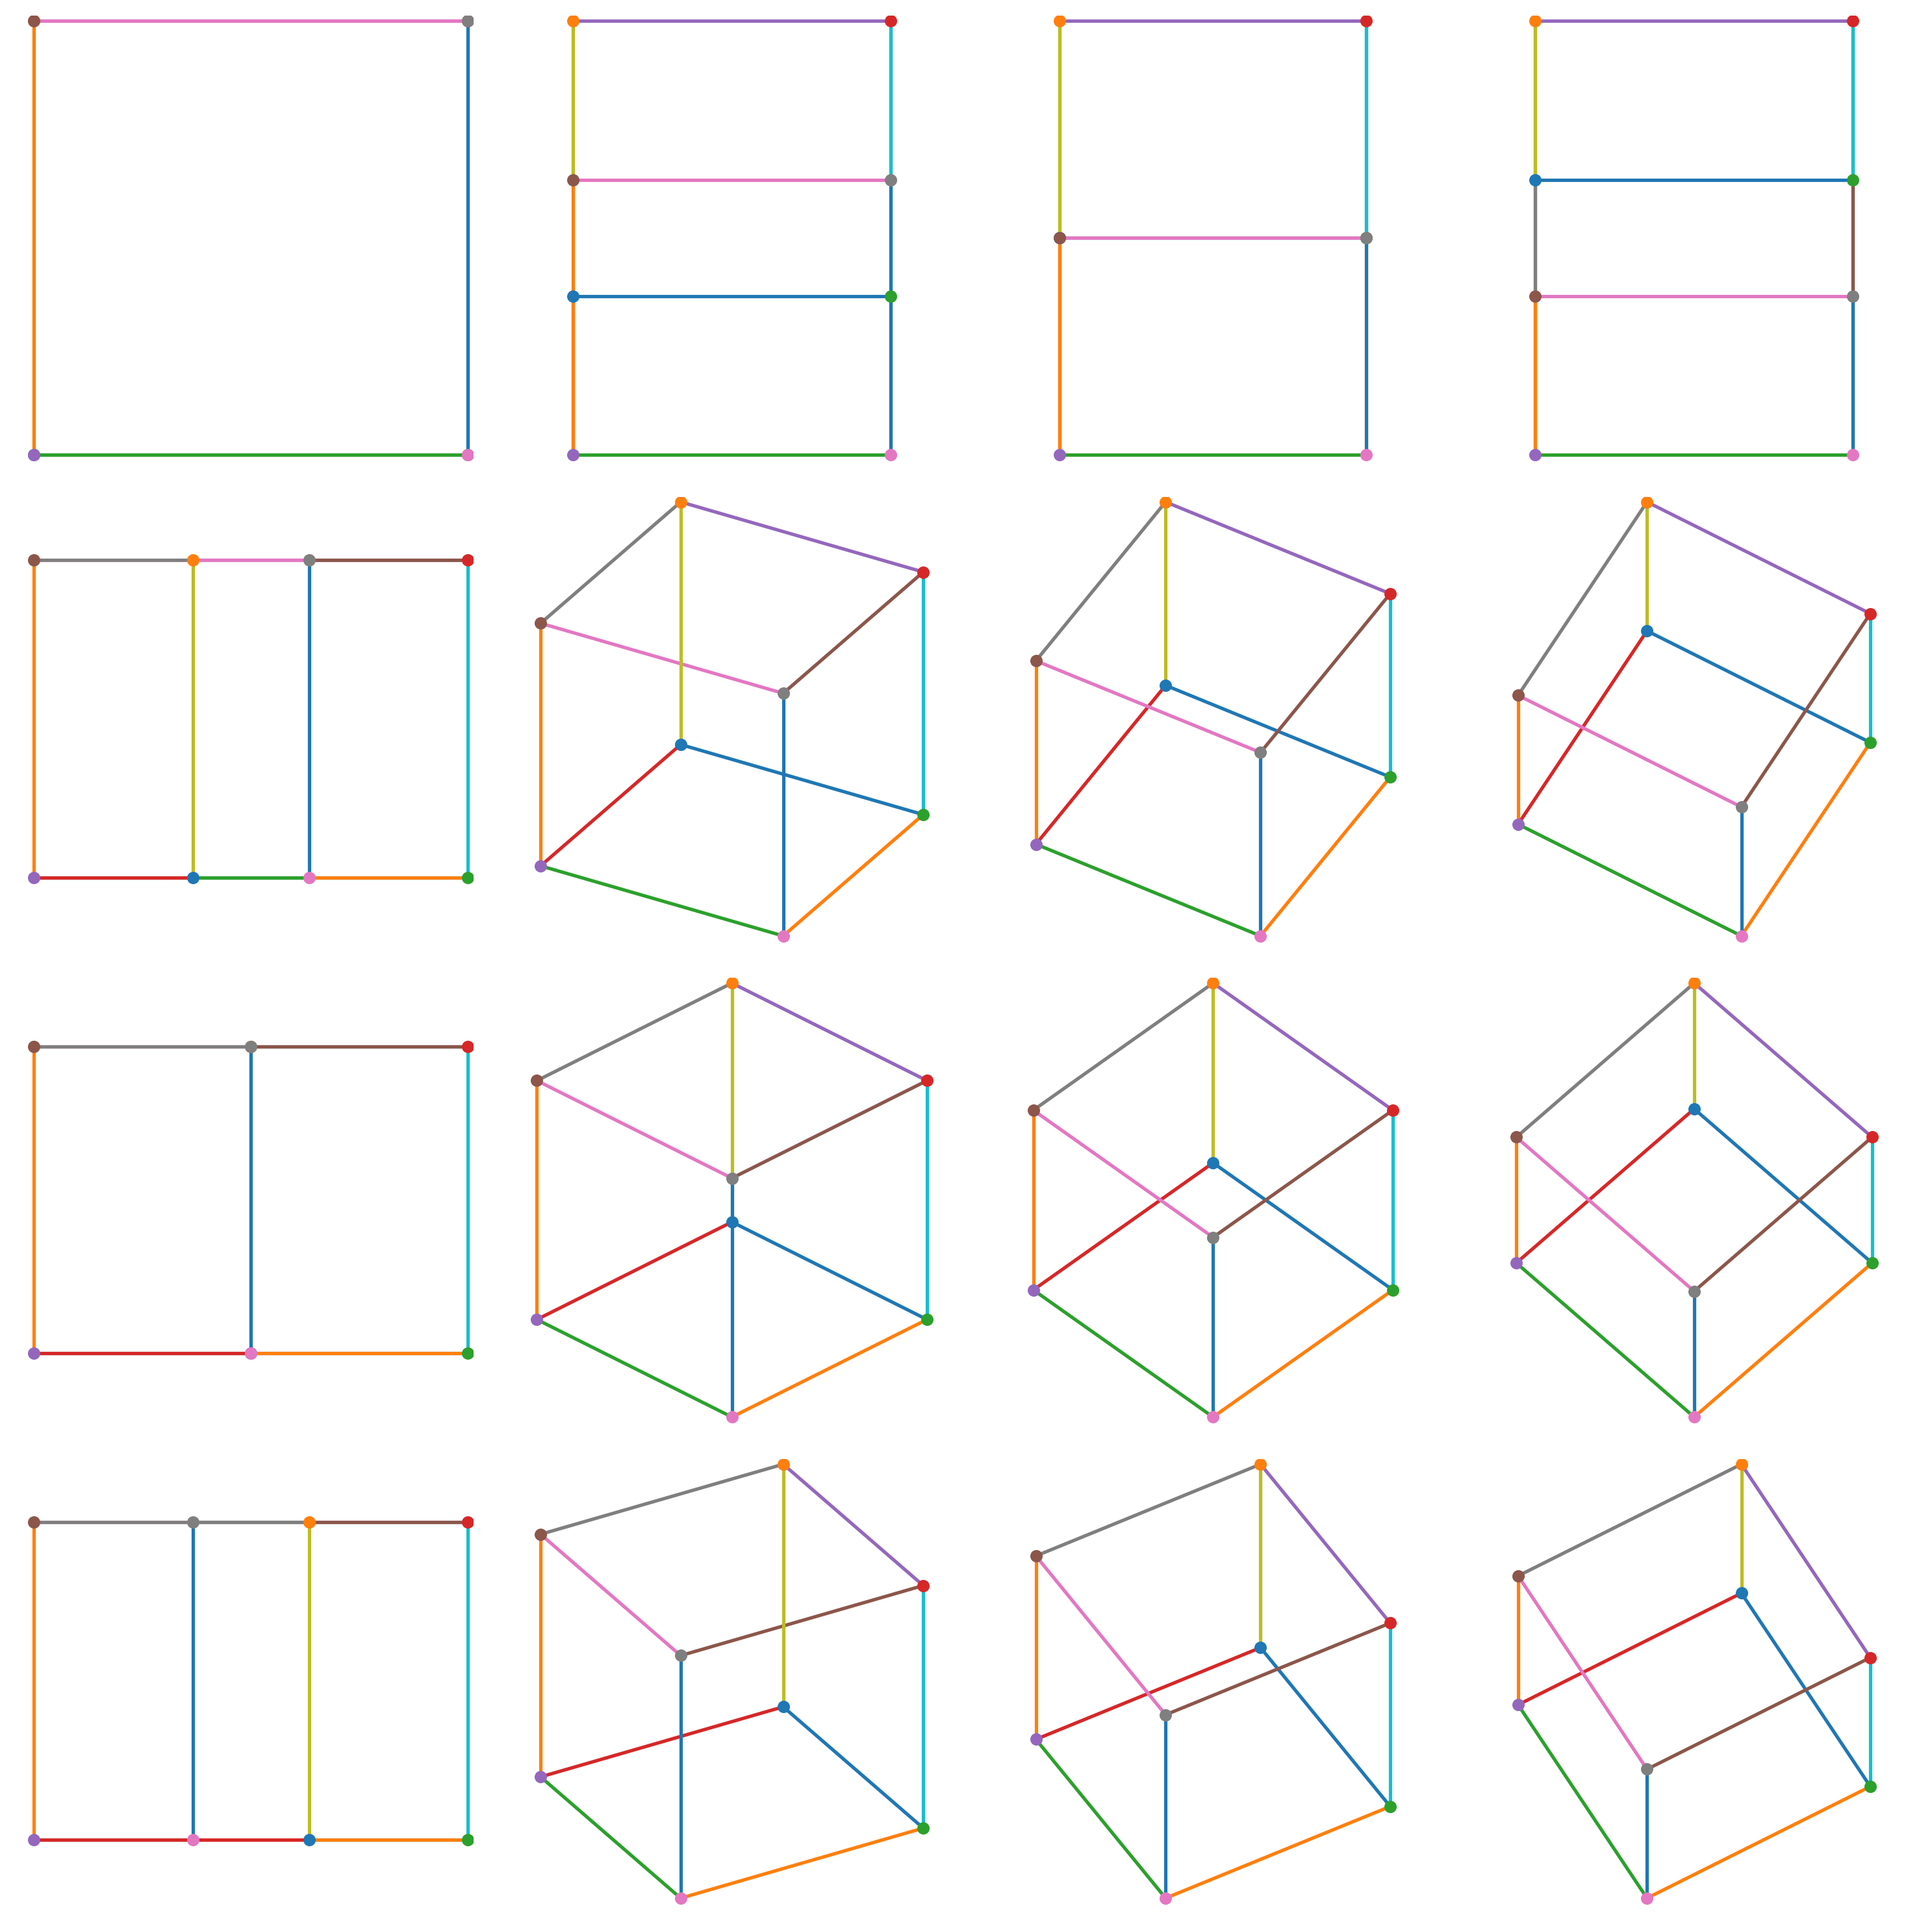

In [34]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
rc_params = get_rc_params(4, 4, (3, 3))
with plt.rc_context(rc_params):
    fig, axes = subplots_3D(4, 4)
    axes = np.ravel(axes)
    for i, (azim, elev) in enumerate(itertools.product([0, 30, 45, 60], [0, 30, 45, 60])):
        ax = axes[i]
        set_axes_3D_equal(ax)
        plot_cube_3D(ax)
        ax.view_init(azim=azim, elev=elev) # view init has to be called first, otherwise calculation is off

        # Fix scaling
        _proj_fix_final(ax)
        # finish plotting regularly
        ax.set_axis_off()

    plt.savefig("4_fix_final.png")